### Data Modeling and Evaluation

In [20]:
# Required package.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%matplotlib inline

RANDOM_SEED = 19730115
rng = np.random.RandomState(RANDOM_SEED)

print("Required packages installed.")

Required packages installed.


In [21]:
def load_pickle_dataset(path):
    """Read pickle.

    Args:
        path (str): The full dataset file.

    Returns:
        dataframe: A pandas dataframe.
    """

    # Get the features and target variable.
    data = pd.read_pickle(path)
    features, target = data.iloc[:, 1:-1].values, data.iloc[:, -1].values

    return features, target


In [22]:

def train_model(X, y, estimator=None, distributions=None):
    """Split the dataframe in training and testing partitions.
    
    
    Args:
        X (Numpy array):
        y (Numpy array):
        estimator (Sklearn model):
        distributions (dict):

    Returns:
        Best estimator, mean test score and 

    
    """
    
    kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=rng)

    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=distributions,
        scoring='f1_micro',
        refit=True,
        verbose=0,
        random_state=rng
    )

    model = search.fit(X, y)
    return model.best_estimator_, model.cv_results_['mean_test_score'], model.cv_results_['mean_score_time']


def test_model(model, X_test, y_test):
    """Test model.
    """
    y_pred = model.predict(X_test)
    return f1_score(y_pred, y_test, average='micro')


In [23]:
train_scores, train_times, test_scores = [], [], []

# baseline estimator.
knn_estimator = KNeighborsClassifier()
knn_estimator_distributions = {
        'n_neighbors': list(range(1, 31, 2)), 
        'weights': ['uniform', 'distance']
}

# source: https://scikit-learn.org/stable/modules/grid_search.html
svm_estimator = SVC()
svm_estimator_distributions =  [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]


In [25]:
vectorizer_names  = ["cv_s100", "tv_s100", "fasttext_cbow_s50", "fasttext_skip_s50", "glove_s50", "wang2vec_cbow_s50", "wang2vec_skip_s50", "word2vec_cbow_s50", "word2vec_skip_s50"]

for name in vectorizer_names:
    print(f"Load {name} vectorized database.")
    reviews_train_features, reviews_train_target = load_pickle_dataset(f"../data/processed/buscape_reviews_train_dataset_{name}.pkl")
    reviews_test_features, reviews_test_target   = load_pickle_dataset(f"../data/processed/buscape_reviews_test_dataset_{name}.pkl")
    
    print(f"Train {name} with vectorized database.")
    model, scores, times = train_model(reviews_train_features, reviews_train_target, knn_estimator, knn_estimator_distributions)
    train_scores.append(list(scores))
    train_times.append(list(times))

    print(f"Test {name} with vectorized database.")
    test_scores.append(test_model(model, reviews_test_features, reviews_test_target))

print("Finish building model.")


Load cv_s100 vectorized database.
Train cv_s100 with vectorized database.
Test cv_s100 with vectorized database.
Load tv_s100 vectorized database.
Train tv_s100 with vectorized database.
Test tv_s100 with vectorized database.
Load fasttext_cbow_s50 vectorized database.
Train fasttext_cbow_s50 with vectorized database.
Test fasttext_cbow_s50 with vectorized database.
Load fasttext_skip_s50 vectorized database.
Train fasttext_skip_s50 with vectorized database.
Test fasttext_skip_s50 with vectorized database.
Load glove_s50 vectorized database.
Train glove_s50 with vectorized database.
Test glove_s50 with vectorized database.
Load wang2vec_cbow_s50 vectorized database.
Train wang2vec_cbow_s50 with vectorized database.
Test wang2vec_cbow_s50 with vectorized database.
Load wang2vec_skip_s50 vectorized database.
Train wang2vec_skip_s50 with vectorized database.
Test wang2vec_skip_s50 with vectorized database.
Load word2vec_cbow_s50 vectorized database.
Train word2vec_cbow_s50 with vectorized

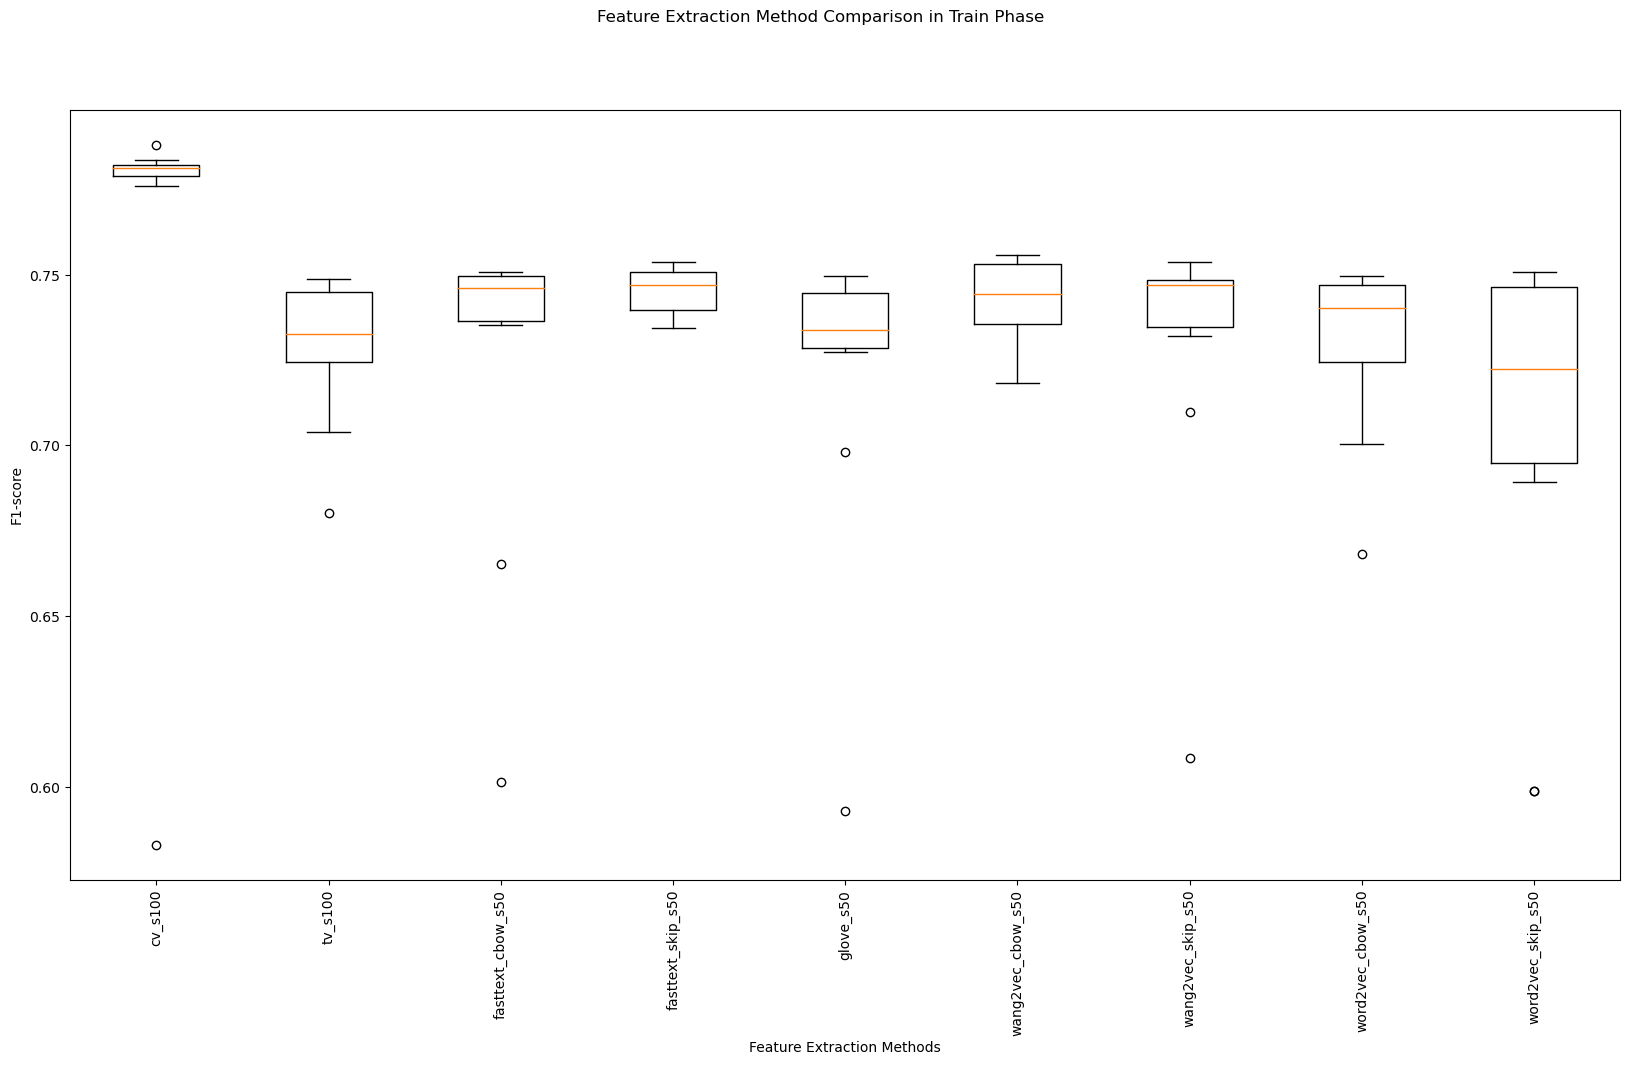

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=90)
fig.suptitle('Feature Extraction Method Comparison in Train Phase')
_ = plt.boxplot(train_scores)
ax.set_xticklabels(vectorizer_names)
ax.set_ylabel('F1-score')
ax.set_xlabel('Feature Extraction Methods')
plt.show()

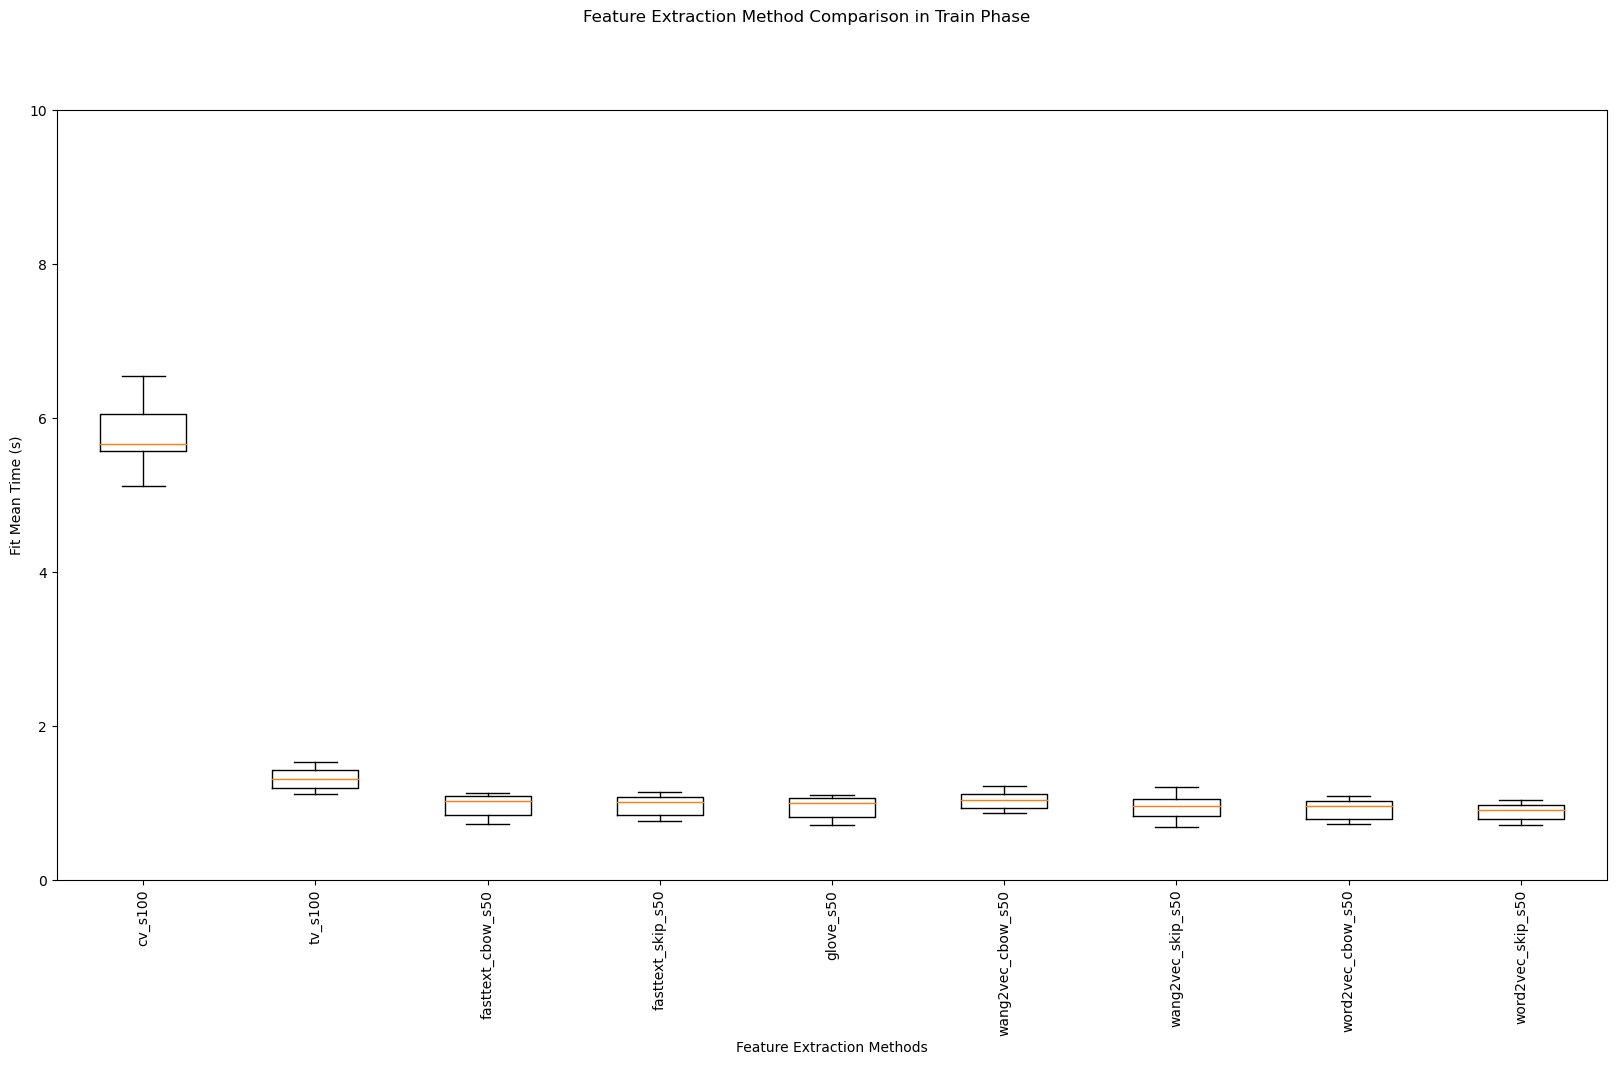

In [29]:
fig, ax = plt.subplots(figsize=(20,10))

plt.xticks(rotation=90)
plt.ylim(0.0, 10.0)

fig.suptitle('Feature Extraction Method Comparison in Train Phase')
_ = plt.boxplot(train_times)
ax.set_xticklabels(vectorizer_names)
ax.set_ylabel('Fit Mean Time (s)')
ax.set_xlabel('Feature Extraction Methods')
plt.show()

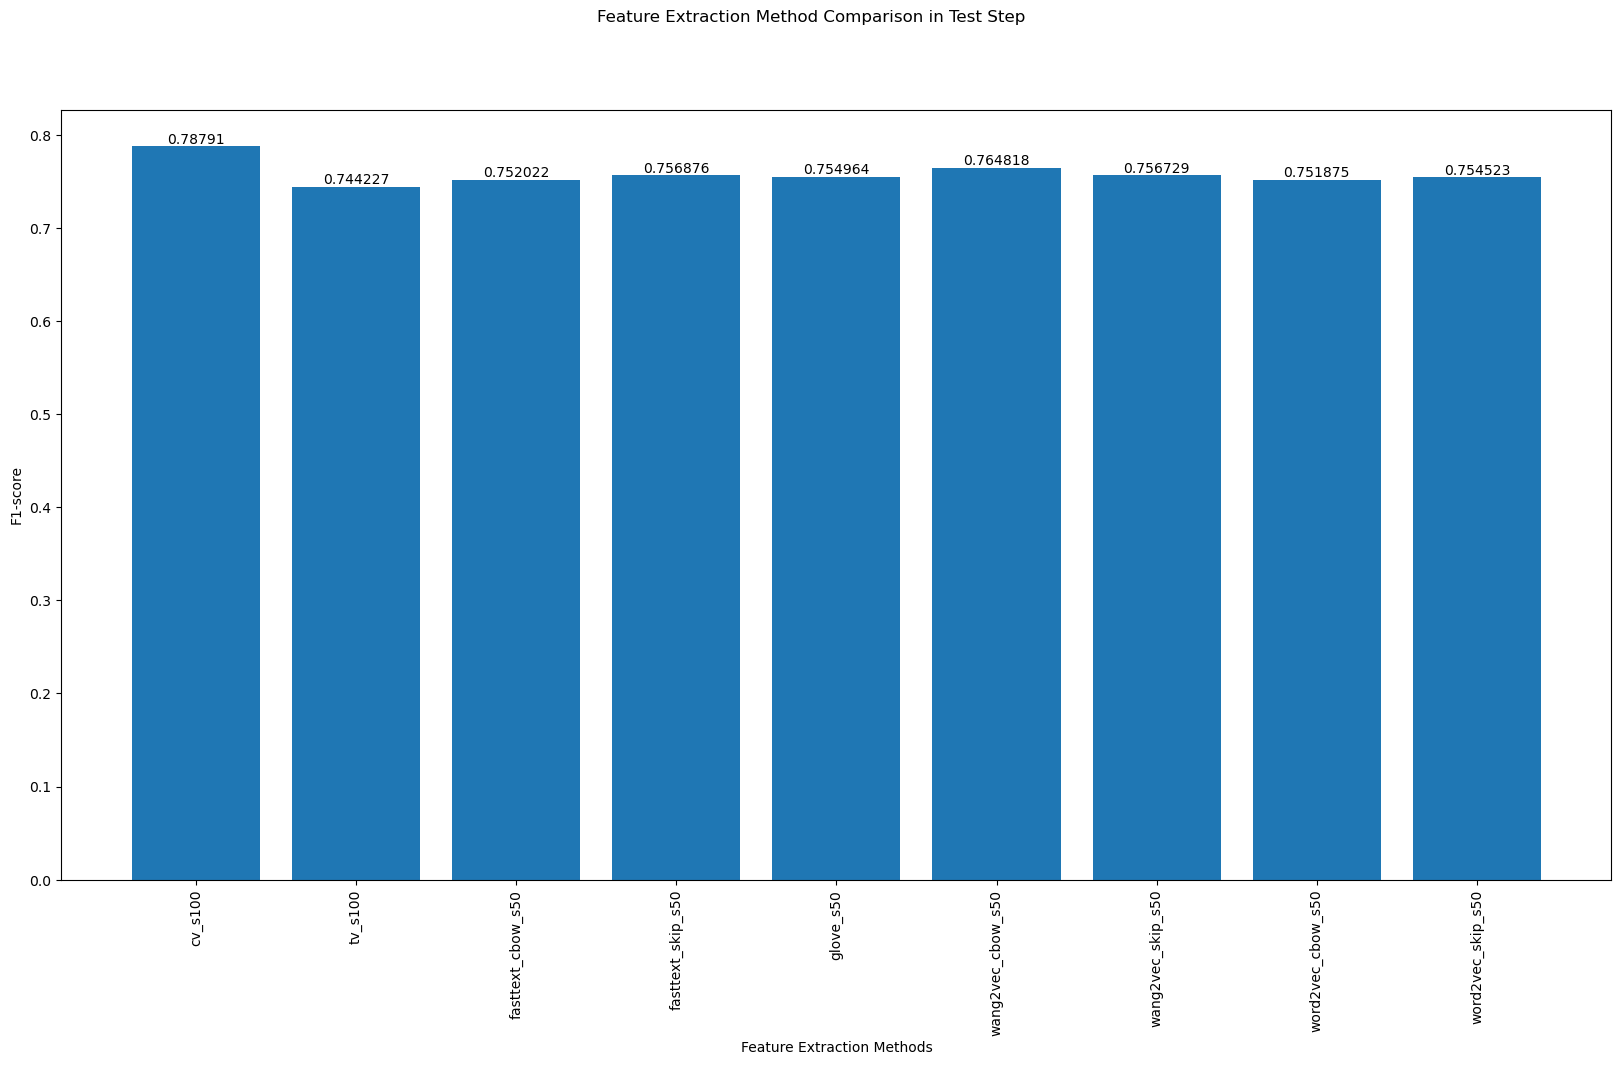

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=90)
fig.suptitle('Feature Extraction Method Comparison in Test Step')
bars = plt.bar(vectorizer_names, test_scores)
ax.set_ylabel('F1-score')
ax.set_xlabel('Feature Extraction Methods')
ax.bar_label(bars)
plt.show()